<a href="https://colab.research.google.com/github/PraveshKoirala/Transformers-Paper/blob/main/Time_Series_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Embedding experiment in Time-Series Transformer.

Adapted from https://github.com/tdjuly/TimeSeriesTransformer


In [417]:
import torch
import math
from torch import nn, Tensor


class PositionalEncoder(nn.Module):
    """
    Adapted from:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    https://github.com/LiamMaclean216/Pytorch-Transfomer/blob/master/utils.py
    """

    def __init__(self, dropout: float = 0.1, max_seq_len: int = 5000, d_model: int = 512):
        """
        Args:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model

        self.dropout = nn.Dropout(p=dropout)

        # Create constant positional encoding matrix with values
        # dependent on position and i
        position = torch.arange(max_seq_len).unsqueeze(1)

        exp_input = torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)

        div_term = torch.exp(exp_input)  # Returns a new tensor with the exponential of the elements of exp_input

        pe = torch.zeros(max_seq_len, d_model)

        pe[:, 0::2] = torch.sin(position * div_term)

        pe[:, 1::2] = torch.cos(position * div_term)  # torch.Size([target_seq_len, dim_val])

        pe = pe.unsqueeze(0).transpose(0, 1)  # torch.Size([target_seq_len, input_size, dim_val])

        # register that pe is not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val]
        """

        add = self.pe[:x.size(1), :].squeeze(1)

        x = x + add

        return self.dropout(x)

In [418]:
from torch import nn, Tensor

class TimeSeriesTransformer(nn.Module):
    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding
    layers and linear mapping layers are separate from the encoder and decoder,
    i.e. the encoder and decoder only do what is depicted as their sub-layers
    in the paper. For practical purposes, this assumption does not make a
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020).
    'Deep Transformer Models for Time Series Forecasting:
    The Influenza Prevalence Case'.
    arXiv:2001.08317 [cs, stat] [Preprint].
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017)
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint].
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """

    def __init__(self,
                 input_size: int,
                 dec_seq_len: int,
                 max_seq_len: int,
                 out_seq_len: int,
                 dim_val: int,
                 n_encoder_layers: int = 4,
                 n_decoder_layers: int = 4,
                 n_heads: int = 4,
                 dropout_encoder: float = 0.2,
                 dropout_decoder: float = 0.2,
                 dropout_pos_enc: float = 0.2,
                 dim_feedforward_encoder: int = 2048,
                 dim_feedforward_decoder: int = 2048,
                 ):
        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            max_seq_len: int, length of the longest sequence the model will
                         receive. Used in positional encoding.
            out_seq_len: int, the length of the model's output (i.e. the target
                         sequence length)
            dim_val: int, aka d_model. All sub-layers in the model produce
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer
                                     of the decoder
        """

        super().__init__()

        self.dec_seq_len = dec_seq_len

        # 1. create 'linear input layer' for 'encoder'
        self.encoder_input_layer = nn.Linear(in_features=input_size, out_features=dim_val)

        # 2. create positional encoder
        self.positional_encoding_layer = PositionalEncoder(d_model=dim_val, dropout=dropout_pos_enc, max_seq_len=max_seq_len)

        # 3. create encoder layers using nn.TransformerDecoder
        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_val,
                                                   nhead=n_heads,
                                                   dim_feedforward=dim_feedforward_encoder,
                                                   dropout=dropout_encoder,
                                                   batch_first=True
                                                   )

        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_encoder_layers, norm=None)

        # 4. create 'linear input layer' for decoder
        self.decoder_input_layer = nn.Linear(in_features=input_size, out_features=dim_val)

        # 5. create decoder layers using nn.TransformerDecoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_val,
                                                   nhead=n_heads,
                                                   dim_feedforward=dim_feedforward_decoder,
                                                   dropout=dropout_decoder,
                                                   batch_first=True
                                                   )
        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=n_decoder_layers, norm=None)

        # 6. create 'linear mapping layer'
        self.linear_mapping = nn.Linear(in_features=dim_val, out_features=out_seq_len)

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor = None, tgt_mask: Tensor = None) -> Tensor:
        """
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input,
                 (S, N, E) if batch_first=False or (N, S, E) if
                 batch_first=True, where S is the source sequence length,
                 N is the batch size, and E is the feature number
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input,
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if
                 batch_first=True, where T is the target sequence length,
                 N is the batch size, E is the feature number.
            src_mask: the mask for the src sequence to prevent the model from
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        src = self.encoder_input_layer(src)
        src = self.positional_encoding_layer(src)
        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length.
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder(src=src)
        decoder_output = self.decoder_input_layer(tgt)
        decoder_output = self.decoder(tgt=decoder_output, memory=src, tgt_mask=tgt_mask, memory_mask=src_mask)
        # print (decoder_output.shape)

        decoder_output = self.linear_mapping(decoder_output)
        # print(decoder_output.shape)

        return decoder_output

In [419]:
def generate_square_subsequent_mask(dim1: int, dim2: int, dim3: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, batch_size * n_heads
        dim2: int. For src and trg masking this must be target sequence length.
        dim3: int. For src masking, this must be encoder sequence length.
              For trg masking, this must be target sequence length
    Return:
        A Tensor of shape [dim1, dim2, dim3]
    """
    return torch.triu(torch.ones(dim1, dim2, dim3) * float('-inf'), diagonal=1)

In [420]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

In [421]:
def get_mape(x, y):
    return np.mean(np.abs((x-y)/x)) * 100


def get_rmse(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

In [422]:
from torch.utils.data import DataLoader
from itertools import chain

def train(data, dmodel):
  dim_val = dmodel  # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
  input_size = 1  # The number of input variables. 1 if univariate forecasting.
  dec_seq_len = 3  # length of input given to decoder. Can have any integer value.
  target_seq_len = 1  # Length of the target sequence, i.e. how many time steps should your forecast cover
  n_encoder_layers = 2  # Number of times the encoder layer is stacked in the encoder
  n_decoder_layers = 2  # Number of times the decoder layer is stacked in the decoder
  n_heads = 4  # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
  batch_size = 64
  enc_seq_len = 5  # length of input given to encoder. Can have any integer value.
  max_seq_len = enc_seq_len  # What's the longest sequence the model will encounter? Used to make the positional encoder


  epochs = 10
  lr = 0.0001
  weight_decay = 0.0001
  ratio = 0.8

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  src_trg_trgy = []
  for i in range(((data.shape[0] - enc_seq_len) // batch_size)*batch_size):
      src = data[i:i + enc_seq_len]
      trg = data[i + enc_seq_len - 1:i + enc_seq_len - 1 + dec_seq_len]
      trg_y = data[i + enc_seq_len -1 + dec_seq_len: i + enc_seq_len -1 + dec_seq_len + target_seq_len]

      src = torch.FloatTensor(np.asarray(src))
      trg = torch.FloatTensor(np.asarray(trg))
      trg_y = torch.FloatTensor(np.asarray(trg_y))

      src_trg_trgy.append((src, trg, trg_y))

  src_trg_trgy=np.array(src_trg_trgy)

  from sklearn.model_selection import ShuffleSplit

  sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  train_index, test_index = next(sss.split(src_trg_trgy)) 
  
  train_set = src_trg_trgy[train_index]
  test_set = src_trg_trgy[test_index]
  
  train_len = train_set.shape[0]
  test_len = test_set.shape[0]

  train = MyDataset([(src.to(device), trg.to(device), trg_y.to(device)) for src, trg, trg_y in train_set.tolist()])
  test = MyDataset([(src.to(device), trg.to(device), trg_y.to(device)) for src, trg, trg_y in test_set.tolist()])

  train_set = DataLoader(dataset=train, batch_size=batch_size, shuffle=False, num_workers=0)
  test_set = DataLoader(dataset=test, batch_size=batch_size, shuffle=False, num_workers=0)
  
  # Make tgt mask for decoder with size:
  # [batch_size*n_heads, target_seq_len, target_seq_len]
  src_mask=None
  tgt_mask = generate_square_subsequent_mask(dim1=n_heads*batch_size, dim2=dec_seq_len, dim3=dec_seq_len).to(device)

   # -----------------------------------build model---------------------------------------------------
  model = TimeSeriesTransformer(
      dim_val=dim_val,
      input_size=input_size,
      dec_seq_len=dec_seq_len,
      max_seq_len=max_seq_len,
      out_seq_len=target_seq_len,
      n_decoder_layers=n_decoder_layers,
      n_encoder_layers=n_encoder_layers,
      n_heads=n_heads
  )
  model.to(device)
  loss_function = nn.MSELoss().to(device)

  # define optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


  # -----------------------------------training---------------------------------------------------
  loss = 0
  best_val_loss = float("inf")
  best_model = None
  best_optimizer = None
  for i in range(epochs):
      for (src, trg, trg_y) in train_set:
          if src.shape[0] % batch_size != 0: continue # skip last entry
          src = torch.reshape(src, (batch_size, enc_seq_len, 1))
          trg = torch.reshape(trg, (batch_size, dec_seq_len, 1))
          src = src.to(device)
          trg_y = trg_y.to(device)
          y_pred = model(src=src, tgt=trg, src_mask=src_mask, tgt_mask=tgt_mask)
          loss = loss_function(y_pred[:, -1, :].reshape(batch_size, 1), trg_y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      if loss < best_val_loss:
          best_val_loss = loss
          best_model = model
          best_optimizer = optimizer
      print('epoch:', i, '\tMSE:', loss.item())
  print("The best loss achieved was:", best_val_loss)
  return None, None, best_model
  model = best_model
  model.eval()

  pred = []
  y = []
  for (src, trg, trg_y) in test_set:
      if src.shape[0] % batch_size != 0: continue # skip last entry
      trg_y = list(chain.from_iterable(trg_y.data.tolist()))
      y.extend(trg_y)
      src = torch.reshape(src, (batch_size, enc_seq_len, 1))
      trg = torch.reshape(trg, (batch_size, dec_seq_len, 1))
      # src = torch.reshape(src, (dec_seq_len, 1))
      src = src.to(device)
      with torch.no_grad():
          y_pred = model(src=src, tgt=trg, src_mask=src_mask, tgt_mask=tgt_mask)
          y_pred = y_pred[:, -1, :].reshape(batch_size, 1).tolist()
          pred.extend(y_pred)
  # test forecast results
  test_results = np.array(pred)
  test_real = np.array(y)
  test_MAPE = get_mape(test_real, test_results)
  test_RMSE = get_rmse(test_real, test_results)
  return test_MAPE, test_RMSE, model

## Experiment

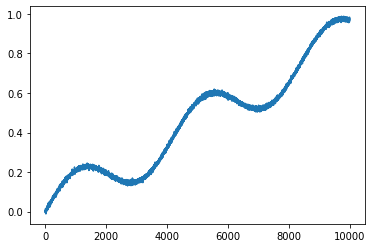

In [423]:
import numpy as np
import matplotlib.pyplot as plt

series = np.arange(0, 1, 0.0001) # trend
series = 15*series + 2*np.sin(series*15) #seasonality
series += np.random.normal(0, .1, series.shape) # irregularities
minm, maxm = np.min(series), np.max(series)
series = series/(maxm-minm) # scale min max
plt.plot(series)

In [424]:
# len(series)-10
l=len(series)
(l//128)*128


9984

In [425]:
mape, rmse, model1 = train(series, 128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 0 	MSE: 0.011327730491757393
epoch: 1 	MSE: 0.005254292860627174
epoch: 2 	MSE: 0.004918302409350872
epoch: 3 	MSE: 0.004961889702826738
epoch: 4 	MSE: 0.0026374799199402332
epoch: 5 	MSE: 0.0025697224773466587
epoch: 6 	MSE: 0.002212050836533308
epoch: 7 	MSE: 0.0026024121325463057
epoch: 8 	MSE: 0.0024981216993182898
epoch: 9 	MSE: 0.002047763206064701
The best loss achieved was: tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


In [426]:
_, _, model2 = train(series, 16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 0 	MSE: 0.010750411078333855
epoch: 1 	MSE: 0.007869209162890911
epoch: 2 	MSE: 0.008394617587327957
epoch: 3 	MSE: 0.006548971403390169
epoch: 4 	MSE: 0.004390509333461523
epoch: 5 	MSE: 0.004827786237001419
epoch: 6 	MSE: 0.0027938345447182655
epoch: 7 	MSE: 0.0025519225746393204
epoch: 8 	MSE: 0.004405640996992588
epoch: 9 	MSE: 0.0036372821778059006
The best loss achieved was: tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)


In [427]:
_, _, model3 = train(series, 8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 0 	MSE: 0.022579742595553398
epoch: 1 	MSE: 0.012098106555640697
epoch: 2 	MSE: 0.013624302111566067
epoch: 3 	MSE: 0.011636914685368538
epoch: 4 	MSE: 0.0071074217557907104
epoch: 5 	MSE: 0.008397424593567848
epoch: 6 	MSE: 0.007197107188403606
epoch: 7 	MSE: 0.007538097910583019
epoch: 8 	MSE: 0.007258618250489235
epoch: 9 	MSE: 0.006531068589538336
The best loss achieved was: tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)


In [428]:
_, _, model4 = train(series, 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 0 	MSE: 0.022080708295106888
epoch: 1 	MSE: 0.01691356673836708
epoch: 2 	MSE: 0.01636725664138794
epoch: 3 	MSE: 0.01599375158548355
epoch: 4 	MSE: 0.014795785769820213
epoch: 5 	MSE: 0.012626316398382187
epoch: 6 	MSE: 0.009341984055936337
epoch: 7 	MSE: 0.011688709259033203
epoch: 8 	MSE: 0.011755028739571571
epoch: 9 	MSE: 0.007512669079005718
The best loss achieved was: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


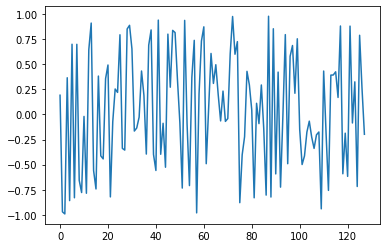

In [429]:
import matplotlib.pyplot as plt

plt.plot(model1.encoder_input_layer.weight.detach().cpu())

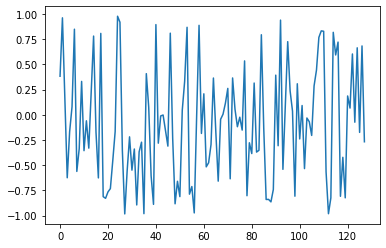

In [430]:
plt.plot(model1.encoder_input_layer.bias.detach().cpu())
plt.show()

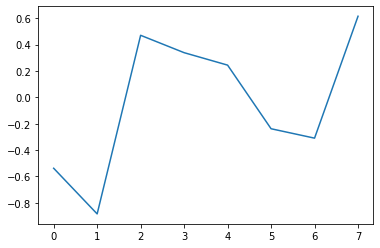

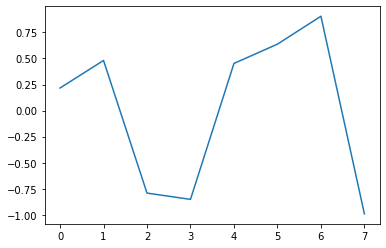

In [431]:
plt.plot(model3.encoder_input_layer.weight.detach().cpu())
plt.show()
plt.plot(model3.encoder_input_layer.bias.detach().cpu())
plt.show()